<a href="https://colab.research.google.com/github/DmitriyShalashov/travels-rec-sys/blob/main/ranking_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.cluster import KMeans
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
!pip install lightgbm
!pip install plotly

In [3]:
import lightgbm as lgb
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',  # Оптимизируем NDCG
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'num_boost_round': 100,
}
from sklearn.metrics import ndcg_score


In [4]:
def split_array(arr, chunk_size):
    return [arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size)]

In [5]:
extended=pd.read_csv("extended.csv")
extended=extended.sort_values(["id","group_id"])


print(extended["id"].nunique())
print(extended.shape)
print(extended.isna().sum())

groups_with_0 = extended.groupby(['id', 'group_id'])['Выбран'].apply(lambda x: 1 in x.values)
groups_to_keep = groups_with_0[groups_with_0].reset_index()[['id', 'group_id']]
filtered_df = extended.merge(groups_to_keep, on=['id', 'group_id'], how='inner')


grouped_extended_prices=filtered_df[filtered_df["Выбран"]==1].groupby("id")["Стоимость билета"].mean()
grouped_extended_time=filtered_df[filtered_df["Выбран"]==1].groupby("id")["Время полета (сек)"].mean()

grouped_extended=pd.DataFrame(grouped_extended_prices)
grouped_extended["Время полета (сек)"]=grouped_extended_time

filtered_df.shape


29466
(294655, 5)
id                    0
Стоимость билета      0
Выбран                0
Время полета (сек)    0
group_id              0
dtype: int64


(294652, 5)

In [6]:
from sklearn.preprocessing import StandardScaler

std_scaler=StandardScaler()

clusterizer=KMeans(n_clusters=3)
clusters_predicts=clusterizer.fit_predict(std_scaler.fit_transform(grouped_extended))

clustered_extended=grouped_extended
clustered_extended["cluster"]=clusters_predicts

px.scatter(data_frame=clustered_extended, x="Время полета (сек)", y="Стоимость билета",
           color="cluster")

In [163]:
from sklearn.cluster import DBSCAN

clusterizer=DBSCAN(eps=0.5, min_samples=1000)
clusters_predicts=clusterizer.fit_predict(std_scaler.fit_transform(grouped_extended))

clustered_extended=grouped_extended
clustered_extended["cluster"]=clusters_predicts

px.scatter(data_frame=clustered_extended, x="Время полета (сек)", y="Стоимость билета",
           color="cluster")

In [7]:
new_users=clustered_extended[clustered_extended["cluster"]==0]

filtered_df=filtered_df[filtered_df["id"].isin(new_users.index)]

grouped = filtered_df.groupby(['id', 'group_id']).size().reset_index(name='count')

filtered_groups = grouped[grouped['count'] == 5]

filtered_df = filtered_df.merge(filtered_groups[['id', 'group_id']], on=['id', 'group_id'], how='inner')

In [21]:
filtered_df.head(15000).tail(40)

,id,Стоимость билета,Выбран,Время полета (сек),group_id
14960,3280.0,4319.00,1.0,9901.0,2
14961,3280.0,4651.89,0.0,14562.0,2
14962,3280.0,3530.38,0.0,13731.0,2
14963,3280.0,6138.00,0.0,14771.0,2
14964,3280.0,5310.85,0.0,12853.0,2
14965,3281.0,6874.00,1.0,7949.0,1
14966,3281.0,7894.27,0.0,8048.0,1
14967,3281.0,5647.16,0.0,12263.0,1
14968,3281.0,9139.09,0.0,11652.0,1
14969,3281.0,8383.74,0.0,10557.0,1


In [50]:
X_train_data=-1*filtered_df[["Время полета (сек)","Стоимость билета"]].iloc[14995:]
y_train_data=filtered_df["Выбран"].iloc[14995:]

X_test_data=-1*filtered_df[["Время полета (сек)","Стоимость билета"]].iloc[:14995]
y_test_data=filtered_df["Выбран"].iloc[:14995]

X_train_data

,Время полета (сек),Стоимость билета
14995,-7890.0,-5584.00
14996,-14908.0,-7309.21
14997,-12140.0,-5402.21
14998,-12066.0,-5820.69
14999,-12163.0,-5695.41
...,...,...
137130,-6565.0,-18874.00
137131,-10634.0,-26715.72
137132,-11323.0,-23956.50
137133,-5058.0,-27340.79


In [51]:
from sklearn.preprocessing import MinMaxScaler

params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'num_boost_round': 100,
}


train_data = lgb.Dataset(X_train_data, label=y_train_data, group=[5 for _ in range(X_train_data.shape[0]//5)])
valid_data = lgb.Dataset(X_test_data, label=y_test_data, group=[5 for _ in range(X_test_data.shape[0]//5)], reference=train_data)

In [52]:
model = lgb.train(params, train_data, valid_sets=[valid_data])

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 122140, number of used features: 2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [53]:
predicts=model.predict(X_test_data)

print([x.tolist().index(max(x)) for x in split_array(predicts,5)])
print([x.tolist().index(max(x)) for x in split_array(y_test_data.values,5)])

ndcg = ndcg_score(split_array(y_test_data,5), split_array(predicts,5))

print("NDCG:",ndcg)

[0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 4, 0, 0, 1, 1, 2, 0, 0, 4, 1, 0, 2, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 3, 1, 4, 0, 4, 2, 1, 0, 2, 4, 2, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 2, 4, 0, 0, 1, 4, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 2, 2, 0, 3, 0, 2, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 4, 2, 0, 4, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 3, 0, 3, 0, 1, 3, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 2, 0, 0, 0, 0, 1, 1, 3, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 3, 0, 0, 4, 0, 1, 4, 0, 0, 0, 0, 1, 3, 0, 1, 0, 1, 0, 0, 0, 1, 0, 3, 1, 0, 0, 2, 1, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 3, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 4, 3, 4, 

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

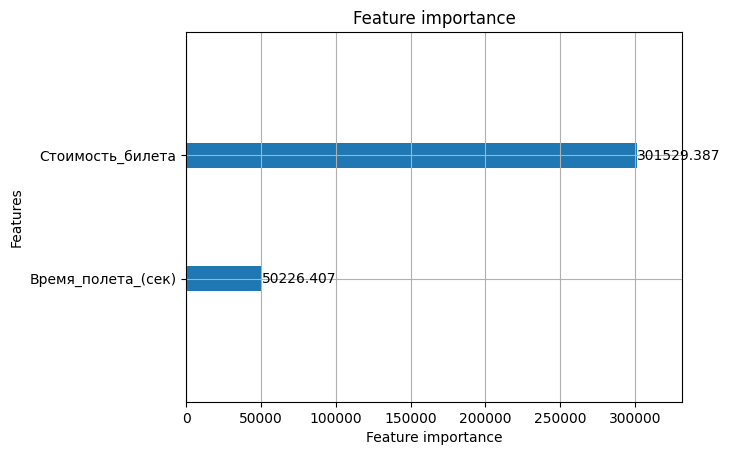

In [54]:
lgb.plot_importance(model, importance_type='gain')

In [58]:
model.save_model('model.txt')